In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
%%capture
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_palette('colorblind')
sns.set_style('whitegrid')
!pip install pingouin
import pingouin
from spacy.lang.en.stop_words import STOP_WORDS
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
!pip install contractions
import contractions
from collections import Counter
import re
from tqdm import tqdm
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# Loading the Dataset

We will start by loading our data, then dropping any duplicates. After that we will check the shape to understand the amount of data we are working with.

In [3]:
movies = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
movies.drop_duplicates(inplace = True)
display(movies.head())

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


We can see that our data has 49582 records and 2 columns. This is a lot of data especially when you consider that it is a Natural Language Processing task we are working on. As such, we will take a random sample of 10000 records to work with.

# Sampling

In [4]:
movies_copy = movies.copy()
movies_df = movies_copy.sample(n = 10000, random_state = 42).reset_index(drop = True)
movies_df.head()

,review,sentiment
0,"""Soul Plane"" is a horrible attempt at comedy t...",negative
1,Guest from the Future tells a fascinating stor...,positive
2,"""National Treasure"" (2004) is a thoroughly mis...",negative
3,"OK. First said, I just wanted to check whether...",negative
4,"I haven't always been a fan, but the show grew...",positive


# Exploratory Data Analysis

## How many positive and negative reviews are there?

We will use a countplot to answer the above asked question;

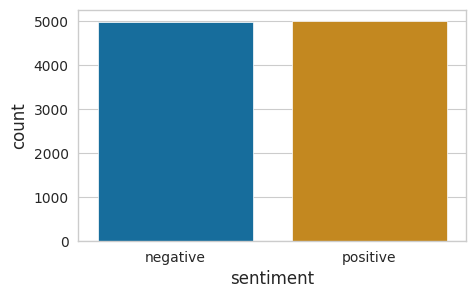

In [5]:
plt.figure(figsize = (5,3))
sns.countplot(data = movies_df, x = 'sentiment')
plt.show()

From the above countplot, we can see that negative and positive reviews are balanced. This is good as the Machine Learning models that will be fit later to predict sentiment will have a lot of data to learn from, from both classes.

## Is there a difference between the number of characters in negative and positive reviews?

100%|██████████| 10000/10000 [00:00<00:00, 764951.21it/s]


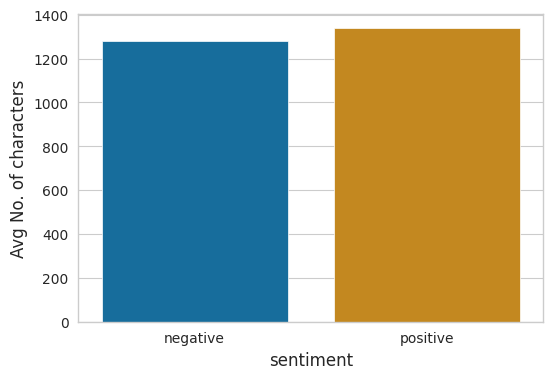

In [6]:
## Creating a new column of number of characters in reviews.
tqdm.pandas()
movies_df['num_char'] = movies_df['review'].progress_apply(lambda x: len(x))
# Plotting a barplot of average num_char vs sentiment
plt.figure(figsize = (6,4))
sns.barplot(data = movies_df, x = 'sentiment', y = 'num_char', ci = False)
plt.ylabel('Avg No. of characters')
plt.show()

From the above barplot, we can see that there is a slight difference in the average number of characters between positive and negative reviews.

We will conduct a t-test to test this out but before then, we will have a look at the distribution of number of characters across the 2 categories of sentiments.

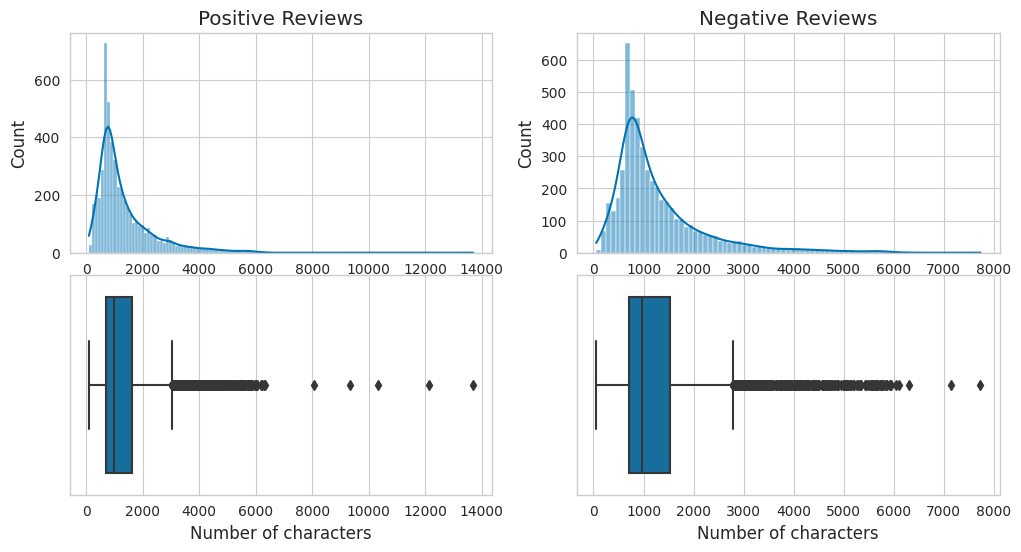

In [7]:
fig, ax =plt.subplots(2,2, figsize = (12,6))
sns.histplot(data = movies_df[movies_df['sentiment']=='positive'], x = 'num_char',  ax =ax[0,0], kde = True)
ax[0,0].set_title("Positive Reviews")
ax[0,0].set_xlabel('Number of characters')
sns.histplot(data = movies_df[movies_df['sentiment']=='negative'], x = 'num_char',  ax =ax[0,1], kde = True)
ax[0,1].set_title("Negative Reviews")
ax[0,1].set_xlabel('Number of characters')
sns.boxplot(data = movies_df[movies_df['sentiment']=='positive'], x = 'num_char', ax = ax[1,0])
ax[1,0].set_xlabel('Number of characters')
sns.boxplot(data = movies_df[movies_df['sentiment']=='negative'], x = 'num_char', ax = ax[1,1])
ax[1,1].set_xlabel('Number of characters')
plt.subplots_adjust(hspace=0.1)
plt.show()

From the above plots, we can see that any review of length more than 6000 is an extreme otlier in either negative or positive reviews. We can also see that we have more extreme `num_char` values in positive reviews than in negative ones.

Next, we will have a look at these entries just to confirm that they are indeed valid entries and not erroneous texts.

In [8]:
#Subsetting for num_char outliers
numchar_outlier = movies_df[movies_df['num_char']>=6000]

The values were checked using the following command;
```{python}
numchar_outlier['review'].values
```
And they are all valid entries.

## Is the difference in number of characters significant?

We will answer this question through hypothesis testing.

H0: The average number of characters across positive and negative reviews is equal.

H1: The average number of characters in positive reviews is greater than average number of characters in negative reviews.

In [9]:
# subsetting for positive and negative reviews
positive_df = movies_df[movies_df['sentiment']=='positive']
negative_df = movies_df[movies_df['sentiment']=='negative']
#performing the hypothesis test
pingouin.mwu(x = positive_df['num_char'],
              y = negative_df['num_char'],
              alternative = 'greater')

,U-val,alternative,p-val,RBC,CLES
MWU,12539417.5,greater,0.392098,0.003162,0.501581


From the above, a p-value of 0.392 suggest that we fail to reject the null and conclude that there is no significant difference in the number of characters in positive and negative reviews.

A RBC (Rank Biserial Correlation) value of 0.003 suggests that positive reviews have slightly more characters than negative reviews but the effect is very small.

Lastly, a CLES (Common Language Effect Size) value 0.5015 suggests that there is approximately a 50% chance of getting a positive review with more characters than a negative review.

## Is there a significant difference between the number of words in positive reviews and negative reviews?

To answer the above question, we will start by expanding contractions using `contractions.fix()`. After that, we will remove punctuations and other unwanted characters such as HTML tags. Next, we will lemmatize and lastly, everything will be converted to lower case.

In [10]:
#Expanding contractions.
movies_df['clean_review'] = movies_df['review'].progress_apply(lambda x: contractions.fix(x))

# Removing tags
non_tagged = [re.sub(r'<br\s*/?>', '', text) for text in movies_df['clean_review']]

# Removing punctuations
alphanumeric = [re.sub(r"[^\w+]",' ', text) for text in non_tagged]

clean_review_tokens = [word_tokenize(review) for review in tqdm(alphanumeric)]


100%|██████████| 10000/10000 [00:07<00:00, 1321.41it/s]


In [11]:
# Lemmatization
nlp = spacy.load('en_core_web_sm')
alphanumeric_joined = [' '.join(review) for review in clean_review_tokens]
alphanumeric_joined[:1]
docs = [nlp(review) for review in tqdm(alphanumeric_joined)]

100%|██████████| 10000/10000 [04:45<00:00, 35.05it/s]


In [12]:
lemmatized = [[token.lemma_ for token in doc] for doc in tqdm(docs)]

100%|██████████| 10000/10000 [00:00<00:00, 11134.81it/s]


In [13]:
# removing trailing spaces
tokens_stripped = [[token.strip() for token in review if token.strip()] for review in tqdm(lemmatized)]
# Adding clean_tokens to movies_df
movies_df['clean_tokens'] = tokens_stripped

100%|██████████| 10000/10000 [00:00<00:00, 34132.06it/s]


Text(0, 0.5, 'Average number of words')

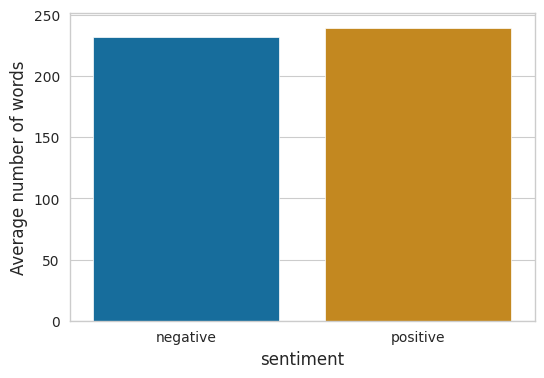

In [14]:
movies_df['clean_review'] = [' '.join(review) for review in movies_df['clean_tokens']]
movies_df['num_words'] = [len(review) for review in movies_df['clean_tokens']]
# A barplot of the average number of words in a review against sentiment
plt.figure(figsize = (6,4))
sns.barplot(data = movies_df, x = 'sentiment', y = 'num_words', ci = True)
plt.ylabel("Average number of words")

From the above barplot, we can see that on average, positive reviews have more words than negative reviews. Next, we will check the distribution of the number of words in positive reviews and negative reviews.

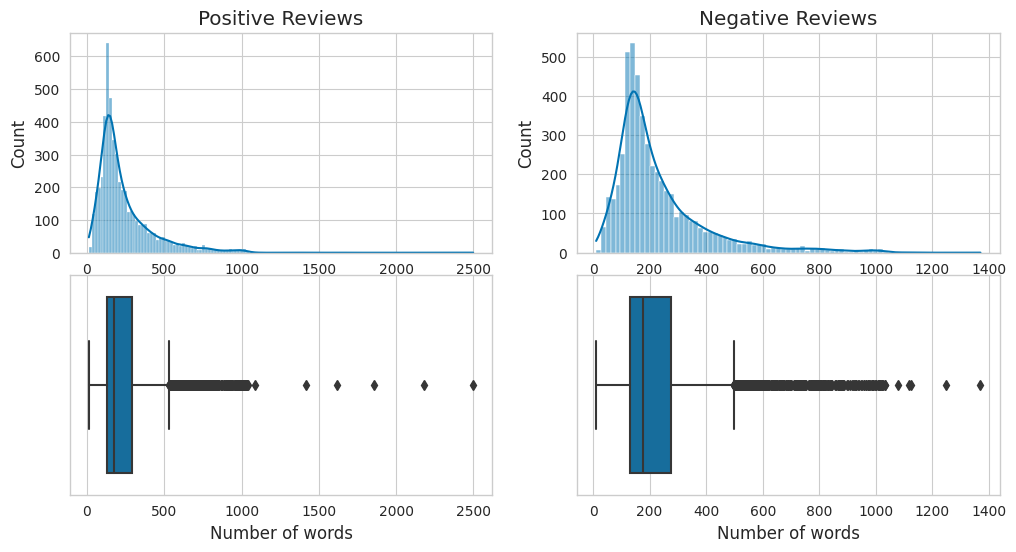

In [15]:
fig, ax =plt.subplots(2,2, figsize = (12,6))
sns.histplot(data = movies_df[movies_df['sentiment']=='positive'], x = 'num_words',  ax =ax[0,0], kde = True)
ax[0,0].set_title("Positive Reviews")
ax[0,0].set_xlabel('Number of words')
sns.histplot(data = movies_df[movies_df['sentiment']=='negative'], x = 'num_words',  ax =ax[0,1], kde = True)
ax[0,1].set_title("Negative Reviews")
ax[0,1].set_xlabel('Number of words')
sns.boxplot(data = movies_df[movies_df['sentiment']=='positive'], x = 'num_words', ax = ax[1,0])
ax[1,0].set_xlabel('Number of words')
sns.boxplot(data = movies_df[movies_df['sentiment']=='negative'], x = 'num_words', ax = ax[1,1])
ax[1,1].set_xlabel('Number of words')
plt.subplots_adjust(hspace=0.1)
plt.show()

As we can see, the plots bear a lot of similarity with the plots for number of characters. Next, we will perform an hypothesis test to see if the difference we saw in the average number of words across positive sentiments is significant.

H0: There is no difference between the average number of words in positive reviews and negative reviews.

H1: The average number of words in positive reviews is greater than in negative reviews.

## Is the difference in number of characters significant?

In [16]:
# subsetting for positive and negative reviews
positive_df = movies_df[movies_df['sentiment']=='positive']
negative_df = movies_df[movies_df['sentiment']=='negative']
#performing the hypothesis test
pingouin.mwu(x = positive_df['num_words'],
              y = negative_df['num_words'],
              alternative = 'greater')

,U-val,alternative,p-val,RBC,CLES
MWU,12479792.5,greater,0.555362,-0.001608,0.499196


From the above, a p-value of 0.515 suggests that we fail to reject the null and conclude that there is no significant difference in the number of words in positive and negative reviews.

A RBC (Rank Biserial Correlation) value of 0 there is a negligible effect of review sentiment on the number of words in a review.

Lastly, a CLES (Common Language Effect Size) value 0.499 suggests that there is approximately a 50% chance of getting a positive review with more characters than a negative review.

## Is there a difference between the average word length between positive reviews and negative reviews?

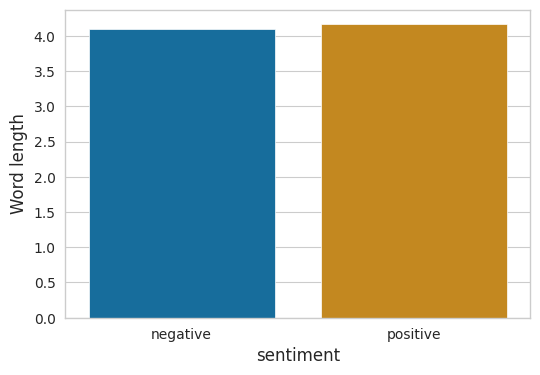

In [17]:
#Calculating average word length
average_word_length = [np.mean(np.array([len(word) for word in review]))for review in movies_df['clean_tokens']]
#Creating a column word_length
movies_df['word_length'] = np.round(average_word_length, 3)
plt.figure(figsize = (6,4))
sns.barplot(data = movies_df, x = 'sentiment', y = 'word_length', ci = True)
plt.ylabel('Word length')
plt.show()

From the above plot, we can see that the average word length of positive reviews is slightly higher than the average wordlength of negative reviews. We will test whether this difference is significant, but before then, we will have a look at the distribution of word lengths across both sentiments.

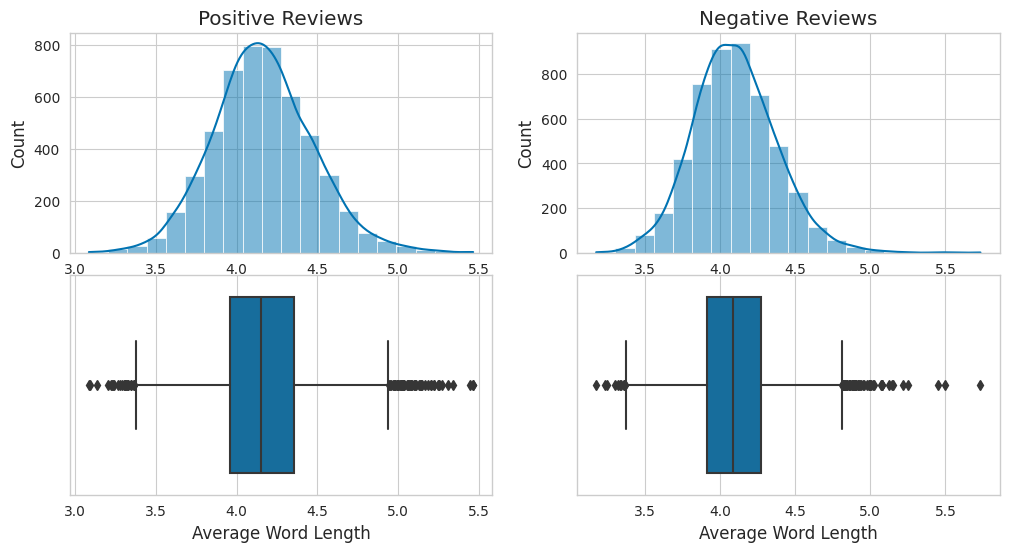

In [18]:
fig, ax =plt.subplots(2,2, figsize = (12,6))
sns.histplot(data = movies_df[movies_df['sentiment']=='positive'], x = 'word_length',  ax =ax[0,0], kde = True, bins = 20)
ax[0,0].set_title("Positive Reviews")
ax[0,0].set_xlabel('Average Word Length')
sns.histplot(data = movies_df[movies_df['sentiment']=='negative'], x = 'word_length',  ax =ax[0,1], kde = True, bins = 20)
ax[0,1].set_title("Negative Reviews")
ax[0,1].set_xlabel('Average Word Length')
sns.boxplot(data = movies_df[movies_df['sentiment']=='positive'], x = 'word_length', ax = ax[1,0])
ax[1,0].set_xlabel('Average Word Length')
sns.boxplot(data = movies_df[movies_df['sentiment']=='negative'], x = 'word_length', ax = ax[1,1])
ax[1,1].set_xlabel('Average Word Length')
plt.subplots_adjust(hspace=0.1)
plt.show()

From the histograms, we can see that word lengths in both positive and negative reviews are normally distributed with an average word length of around 4.2. 

From the boxplots, we can see that the spread of wordlengths in positive reviews is larger than in negative reviews. This can be evidenced by the that values beyond a word length of 5 can be considered outliers in positive reviews whereas this value seems to be approximately 4.9 in negative reviews.

In both positive and negative reviews, we can see that worlengths below approximately 3.2 can be considered outliers too.
Next, we will have a look at these outlier values to confirm is they are indeed made up of valid words.

In [19]:
# Subsetting for outliers
#movies_df[(movies_df['word_length'] > 5 )| (movies_df['word_length'] < 3.2)]['clean_tokens'].values

## Is the difference in average word lengths in positive and negative reviews significant?

In [20]:
# subsetting for positive and negative reviews
positive_df = movies_df[movies_df['sentiment']=='positive']
negative_df = movies_df[movies_df['sentiment']=='negative']
#performing the hypothesis test
pingouin.mwu(x = positive_df['word_length'],
              y = negative_df['word_length'],
              alternative = 'greater')

,U-val,alternative,p-val,RBC,CLES
MWU,14114950.5,greater,2.308465e-29,0.129206,0.564603


From the above, a p-value of 0 suggests that we reject the null and conclude that positive reviews have greater word length than negative reviews.

A RBC (Rank Biserial Correlation) value of 0.114 suggests that even though the word lengths in positive reviews are larger, the effect size is small.

Lastly, a CLES (Common Language Effect Size) value 0.55 suggests that there is approximately a 55% chance of getting a positive review with more characters than a negative review.

In conclusion, even though positive reviews appear to have greater word length on average; the effect size is small meaning that it might not be meaningful in practial context.
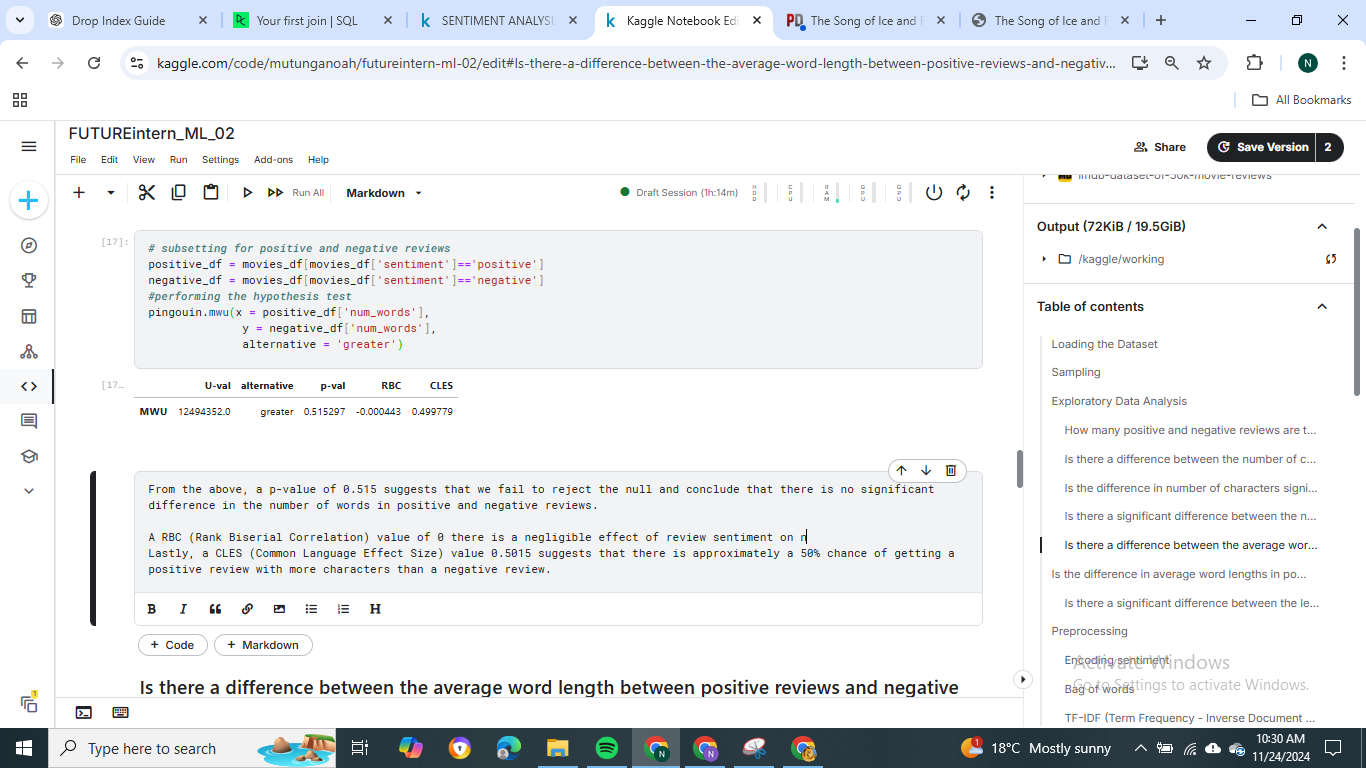

## Which words are most frequent in either positive or negative reviews?

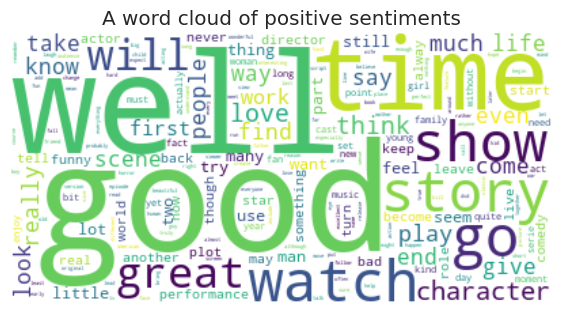

In [21]:
def sentiment_cloud (df,col,title):
    sentiment_text = " ".join(df[col])
    my_wordcloud = WordCloud(background_color='white', stopwords=STOPWORDS.union(['s','film','movie','one','make','see'])).generate(sentiment_text)
    plt.figure(figsize = (7,5))
    plt.imshow(my_wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
sentiment_cloud(positive_df, 'clean_review', 'A word cloud of positive sentiments')

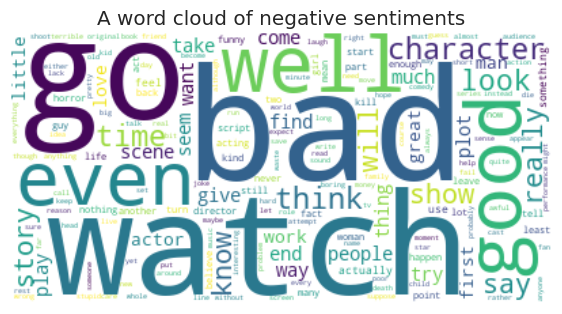

In [22]:
sentiment_cloud(negative_df, 'clean_review', 'A word cloud of negative sentiments')

Next, we will plot count plots of the top 15 word frequencies in both negative and positive reviews.

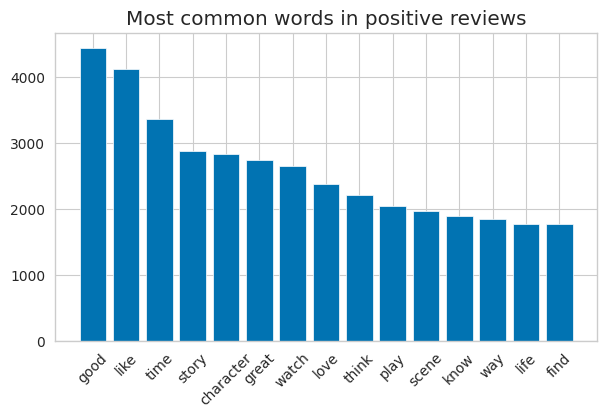

In [23]:
STOP_WORDS.update(['s','film','movie','one','make','see','I'])
def remove_stopwords_and_plot(df, column, title):
    no_stopwords = [word for sublist in df[column] for word in sublist if word not in STOP_WORDS]
    top_10 = Counter(no_stopwords).most_common(15)
    x,y = zip(*top_10)
    plt.figure(figsize = (7,4))
    plt.bar(x,y)
    plt.xticks(rotation = 45)
    plt.title(title)
    plt.show()
remove_stopwords_and_plot(positive_df, 'clean_tokens', 'Most common words in positive reviews')


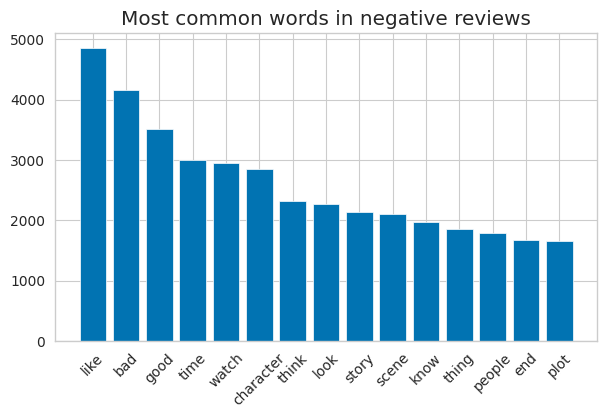

In [24]:
remove_stopwords_and_plot(negative_df, 'clean_tokens', 'Most common words in negative reviews')
